In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

# Load data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_split("D:\\Dropbox\\My work\\krypl-project\\dataSplit\\return-01-within-day")

In [3]:
from sklearn.externals import joblib
from modeling.gridsearch import GridSearch

path = "D:\\Dropbox\\My work\\krypl-project\\models\\return-01-within-day"
grid_search = joblib.load(f'{path}\\tree_search.pkl')

# Prediction on validation set

In [47]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

confusion_matrixes = []
precisions = []
recalls = []
for clf in grid_search.clfs:
    y_pred = clf.predict(X_val)
    confusion_matrixes.append(confusion_matrix(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Precision - recall

Text(0,0.5,'recall')

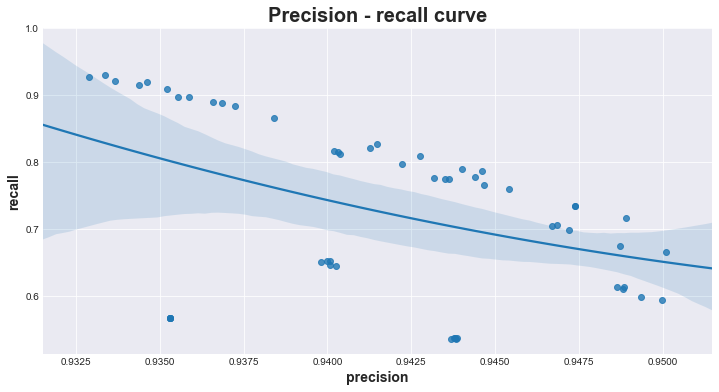

In [48]:
plt.figure(figsize=[12, 6])
sns.regplot(np.array(precisions), np.array(recalls), order=2)
plt.title('Precision - recall curve', fontproperties=title_font)
plt.xlabel('precision', fontproperties=axis_font)
plt.ylabel('recall', fontproperties=axis_font)

# ROC curve

In [49]:
def cm_parts(conf_mat):
    TN = conf_mat[0, 0]
    FN = conf_mat[1, 0]
    FP = conf_mat[0, 1]
    TP = conf_mat[1, 1]
    return TN, FN, FP, TP


def fpr(conf_mat):
    TN, FN, FP, TP = cm_parts(conf_mat)
    return FP / (FP + TN)

# TN = 1, FN = 2, FP = 3, TP = 4
y = [0, 0,  0, 1, 1, 1, 1, 1, 1, 1]
y_true = [0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
conf_mat = confusion_matrix(y_true, y)
np.testing.assert_array_equal(conf_mat, np.array([[1, 3], 
                                                  [2, 4]]))
TN, FN, FP, TP = cm_parts(conf_mat)
assert TN == 1
assert FN == 2
assert FP == 3
assert TP == 4

assert fpr(conf_mat) == (3 / (3+1))

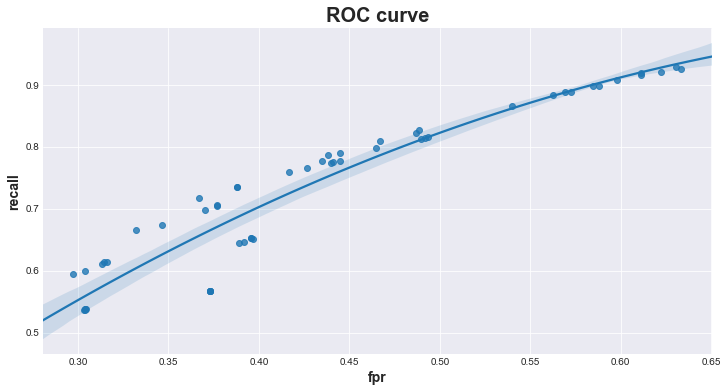

In [50]:
fprs = [fpr(conf_mat) for conf_mat in confusion_matrixes]
plt.figure(figsize=[12, 6])
sns.regplot(np.array(fprs), np.array(recalls), order=2)
plt.title('ROC curve', fontproperties=title_font)
plt.xlabel('fpr', fontproperties=axis_font)
plt.ylabel('recall', fontproperties=axis_font);

# Features importance

In [ ]:
stats = pd.DataFrame({
        'precision': precisions,
        'recall': recalls,
        'fpr': fprs
    })

stats.sort_values('fpr')

In [4]:
clf = grid_search.clfs[19]

In [7]:
features = X_val.columns
importances = clf.feature_importances_
importances_df = pd.DataFrame({'feature': features, 'importance': importances})
importances_df.sort_values('importance', ascending=False)

,feature,importance
15,vol2016,0.1617
9,ac288,0.1344
14,vol288,0.0856
8,ac36,0.0748
0,return,0.0696
16,dv_36_288,0.0690
4,zscore_288_return,0.0515
12,zscore_2016_volume,0.0490
5,pma36,0.0485
13,vol36,0.0469


In [11]:
top_features = importances_df.sort_values('importance', ascending=False)['feature'].head(6)
top_features.values

array(['vol2016', 'ac288', 'vol288', 'ac36', 'return', 'dv_36_288'],
      dtype=object)

# Evaluation on test set

In [55]:
clf = grid_search.clfs[19]

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

def cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, columns=['predicted_0', 'predicted_1'], index=['true_0', 'true_1'])
    return cm


def eval(clf, X, y_true):
    y_pred = clf.predict(X)
    report = classification_report(y_true, y_pred)
    conf_matrix = cm(y_true, y_pred)
    print(conf_matrix, end='\n\n')
    print(f'Precison: %.3f' % precision_score(y_true, y_pred))
    print(f'Recall: %.3f' % recall_score(y_true, y_pred))
    print(f'FPR: %.3f' % fpr(conf_matrix.values))

In [64]:
eval(clf, X_val, y_val)

        predicted_0  predicted_1
true_0         2342          992
true_1        12843        18838

Precison: 0.950
Recall: 0.595
FPR: 0.298


In [65]:
eval(clf, X_test, y_test)

        predicted_0  predicted_1
true_0         3514         1595
true_1        19227        27925

Precison: 0.946
Recall: 0.592
FPR: 0.312


In [66]:
joblib.dump(clf, f'{path}\\tree_selected_01.pkl');

# Export Tree

In [67]:
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file='tree.dot')